This is based on the post https://towardsdatascience.com/machine-learning-for-text-classification-using-spacy-in-python-b276b4051a49 by Susan Li.

Research papers are submitted at different conferences and we want to determine the dominant topic of the conferences based on the titles of the papers. We have a database of paper titles (2507 instances) and their corresponding conference (only 5 different conferences). We will use **spaCy** to analyse the paper titles and extract relevant information and we will try to make a model predicting the conference associated to a given paper, based on its title.

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords

In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
stopwords_en = stopwords.words('english')
len(stopwords_en)
stopwords_en[:10]

179

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [11]:
df = pd.read_csv('research_paper.csv')
len(df)
df.head()

2507

,Title,Conference
0,Innovation in Database Management: Computer Sc...,VLDB
1,High performance prime field multiplication fo...,ISCAS
2,enchanted scissors: a scissor interface for su...,SIGGRAPH
3,Detection of channel degradation attack by Int...,INFOCOM
4,Pinning a Complex Network through the Betweenn...,ISCAS


In [13]:
df.isnull().sum()

Title         0
Conference    0
dtype: int64

In [33]:
df.Conference.value_counts()

ISCAS       864
INFOCOM     515
VLDB        423
WWW         379
SIGGRAPH    326
Name: Conference, dtype: int64

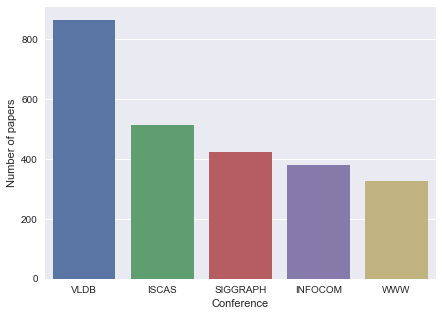

In [52]:
plt.figure(figsize=(7,5))
ax = sns.barplot(x=df.Conference.unique(), y=df.Conference.value_counts())
ax.set(xlabel='Conference', ylabel='Number of papers');

In [273]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.33, random_state = 11)

In [274]:
train.head()
test.head()

,Title,Conference
2006,Stochastic Ordering for Internet Congestion Co...,INFOCOM
398,Releasing search queries and clicks privately.,WWW
1676,Memory-efficient scalable video encoder archit...,ISCAS
760,1.25/2.5-Gb/s burst-mode clock recovery circui...,ISCAS
300,A Converter with Fixed Switching Frequency Ada...,ISCAS


,Title,Conference
248,Data fusion - Resolving Data Conflicts for Int...,VLDB
1986,Per-survivor processing Viterbi decoder for Bl...,ISCAS
2105,The VolumePro Real-Time Ray-Casting System.,SIGGRAPH
553,Maximizing capacity with power control under p...,INFOCOM
1920,A 5.3GHz low-phase-noise LC VCO with harmonic ...,ISCAS


In [74]:
! pip install spacy && python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/Benjamin/anaconda/lib/python3.6/site-packages/en_core_web_sm -->
/Users/Benjamin/anaconda/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [70]:
import spacy

In [89]:
nlp = spacy.load('en')
punctuations = string.punctuation

In [90]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [93]:
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords_en and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [106]:
INFO_text = [text for text in train[train['Conference'] == 'INFOCOM']['Title']]
IS_text = [text for text in train[train['Conference'] == 'ISCAS']['Title']]

INFO_clean = cleanup_text(INFO_text)
INFO_clean = ' '.join(INFO_clean).split()
IS_clean = cleanup_text(IS_text)
IS_clean = ' '.join(IS_clean).split()

INFO_counts = Counter(INFO_clean)
IS_counts = Counter(IS_clean)
INFO_common_words = [word[0] for word in INFO_counts.most_common(20)]
INFO_common_counts = [word[1] for word in INFO_counts.most_common(20)]
IS_common_words = [word[0] for word in IS_counts.most_common(20)]
IS_common_counts = [word[1] for word in IS_counts.most_common(20)]

In [107]:
INFO_text[:3]
INFO_clean[:5]
INFO_common_words[:5]
INFO_common_counts[:5]

['Stochastic Ordering for Internet Congestion Control and its Applications.',
 'PW-MAC: An energy-efficient predictive-wakeup MAC protocol for wireless sensor networks.',
 'A novel method to detect bad data injection attack in smart grid.']

['stochastic', 'ordering', 'internet', 'congestion', 'control']

['network', 'networks', 'wireless', 'base', 'sensor']

[95, 79, 68, 31, 29]

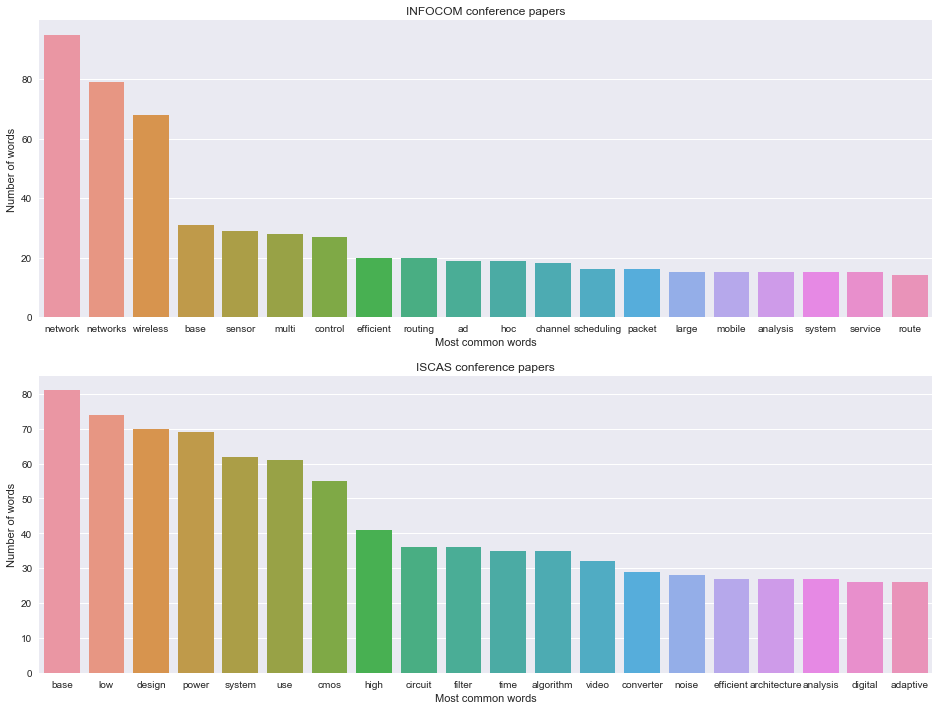

In [126]:
fig, ax = plt.subplots(2,1, figsize = (16,12))
sns.barplot(x=INFO_common_words, y=INFO_common_counts, ax = ax[0])
ax[0].set(xlabel = 'Most common words', ylabel = 'Number of words', title = 'INFOCOM conference papers');
sns.barplot(x=IS_common_words, y=IS_common_counts, ax = ax[1])
ax[1].set(xlabel = 'Most common words', ylabel = 'Number of words', title = 'ISCAS conference papers');

### Model

Another way to clean the text data:

In [262]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

In [263]:
from sklearn.base import TransformerMixin

In [264]:
class CleanTextTransformer(TransformerMixin):
    
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self

def clean_text(text):
    text = text.strip().replace("\n"," ").replace("\r"," ")
    text.lower()
    return text

In [265]:
from spacy.lang.en import English
parser = English()

def tokenize_text(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)  # I think the if statement in useless with last spacy version. 
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

In [266]:
[tok.lemma_ for tok in parser('I am 33 years old.')]

['I', 'be', '33', 'year', 'old', '.']

In [267]:
from sklearn.feature_extraction.text import CountVectorizer
# Convert a collection of text documents to a matrix of token counts.
# Example
corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?'
         ]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()
X.toarray()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [268]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

vectorizer = CountVectorizer(tokenizer=tokenize_text, ngram_range=(1,1))
clf = LinearSVC()

def PrintNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top_class_1 = coefs_with_fns[:N]
    top_class_2 = coefs_with_fns[:-(N+1):-1]
    print("Class 1 best:")
    for feat in top_class_1:
        print(feat)
    print('Class 2 best:')
    for feat in top_class_2:
        print(feat)

In [289]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('cleanText', CleanTextTransformer()),
                 ('vectorizer', vectorizer)])

In [290]:
train_1 = train.Title.values
label_train_1 = train.Conference.values

test_1 = test.Title.values
label_test_1 = test.Conference.values

X_train = pipe.fit_transform(train_1)
clf.fit(X_train, label_train_1)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [291]:
vocab = vectorizer.get_feature_names()
vocab[500:505]

['characteristic', 'characterization', 'characterize', 'charge', 'chartis']

In [292]:
from sklearn.metrics import accuracy_score

X_test = pipe.transform(test_1)
preds = clf.predict(X_test)
print("accuracy:", accuracy_score(label_test_1, preds))

print("Top 10 features used to predict: ")
PrintNMostInformative(vectorizer, clf, 10)

accuracy: 0.7415458937198067
Top 10 features used to predict: 
Class 1 best:
(-0.9061663976537936, 'database')
(-0.8078875016291525, 'road')
(-0.6541714344016107, 'complex')
(-0.6389457263790526, 'chip')
(-0.6307084110146786, 'semantic')
(-0.6254001476884052, 'rfid')
(-0.5879336962714842, 'circuit')
(-0.5776401709054855, 'amplifier')
(-0.5707304796852183, 'analytics')
(-0.5700450378067686, 'digital')
Class 2 best:
(1.045056527887729, 'ip')
(0.9660019735513289, 'implication')
(0.9346296036305304, 'qos')
(0.9293197295574934, 'replacement')
(0.8824976174551015, 'congestion')
(0.8671077035664047, 'schedule')
(0.8669471876319711, 'queue')
(0.8549217825939037, 'bloom')
(0.8502960854982747, 'network')
(0.8306609248685759, 'attack')


In [293]:
preds[:5]

array(['VLDB', 'ISCAS', 'SIGGRAPH', 'ISCAS', 'ISCAS'], dtype=object)

In [299]:
from sklearn.metrics import classification_report

print(classification_report(label_test_1, preds))

              precision    recall  f1-score   support

     INFOCOM       0.75      0.76      0.75       162
       ISCAS       0.87      0.81      0.84       296
    SIGGRAPH       0.63      0.72      0.67       107
        VLDB       0.66      0.65      0.66       143
         WWW       0.65      0.68      0.67       120

   micro avg       0.74      0.74      0.74       828
   macro avg       0.71      0.72      0.72       828
weighted avg       0.75      0.74      0.74       828

